<a href="https://colab.research.google.com/github/esorq/ml-portfolio/blob/main/Assembly_verification_using_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assembly verification using an autoencoder
--------
**Autoencoders** are a class of neural networks that can be used for unsupervised learning. The basic idea of an autoencoder is to learn a compressed representation of the input data. The network is trained to reconstruct the input data from this compressed representation, and the difference between the original data and the reconstructed data is called the reconstruction error. If the autoencoder is trained on normal data, it should be able to reconstruct the normal data with low reconstruction error. However, if the autoencoder is presented with non-normal/anamolous data, the reconstruction error will be high because the network cannot effectively compress and reconstruct the unusual data.

In this project normal data is represented by valid product assemblies and non-normal data is represented by non-valid product assemblies. The hypothesis is that an **Autoecnoder** can learn to reconstruct valid assemblies whereas it will have problems reconstruction non-valid assemblies.

This notebook can be divided into the following 5 parts.

1. Environment Setup
2. Data preparation
3. Create model blueprint
4. Instatiate a model and train
5. Test the model

---------------------------
This is a correct assembly:

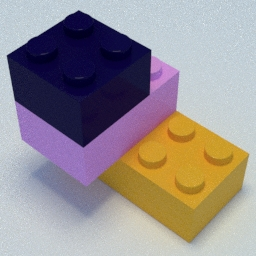

Below is an example of classifactions based on reconstruction errors:

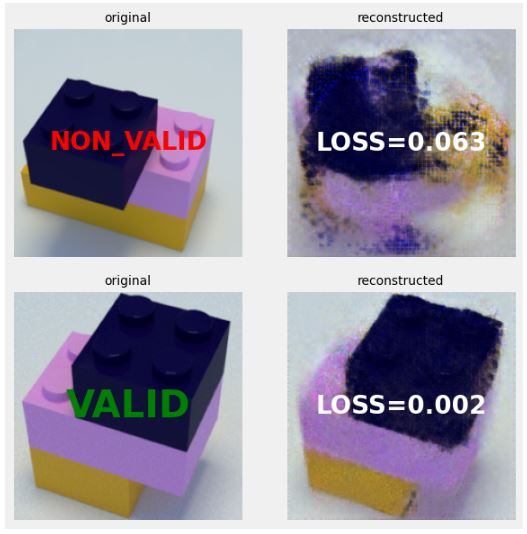

## 1. **Environment Setup**
---------




What compute do we have access to?

In [1]:
!nvidia-smi

Tue Jun 20 22:13:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Lets import some libraries

In [2]:
import os
import torch
import torchvision

Device related errors are common errors when working on machine learning project with PyTorch. They happen due to misalignment in terms of where interacting entities of your project are stored. We defualt `device` to GPU(cuda) if availble and otherwise fall back to CPU.

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [4]:
#Setting up the variable HOME so that we can easily redirect to the root directory when needed
HOME = os.getcwd()
print(HOME)

/content


In [5]:
# # Import the scripts from the portfolio
# !git clone https://github.com/esorq/ml-portfolio
# !mv ml-portfolio/scripts scripts # moving the scripts folder to a new folder with the name scripts in the root directory
# !rm -rf ml-portfolio # remove the rest that is not needed

# os.chdir("scripts")
# import data_setup, engine
# from helper_functions import download_data, set_seeds, plot_loss_curves
# from predictions import pred_and_plot_image
# os.chdir('..') #going one step back

## 2. **Data Preparation**
Downloading the data from GitHub and unzipping it in the data folder




In [6]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/") #creating a Path object for a data directory

if data_path.is_dir():  #checking if directory exists
  print(f"Image directory allready exists..")
else:  # creating the directory if not existing
  print(f"Image directory {data_path} does not exist, creating the directory")
  data_path.mkdir(parents=True, exist_ok=True)

Image directory data does not exist, creating the directory


In [7]:
#download data from github
zip_path = data_path / "synthetic_lego.zip"

if zip_path.is_file():
  print("zipfile allready exist")
else:
  with open(data_path / "synthetic_lego.zip", "wb") as f:
    request = requests.get("https://github.com/esorq/ml-portfolio/blob/main/data/synthetic_lego.zip?raw=true")
    print("downloading data...")
    f.write(request.content)

downloading data...


In [8]:
#extract images from file and remove zip-file
if zip_path.is_file():
  with zipfile.ZipFile(data_path / "synthetic_lego.zip", "r") as zip_ref:
    print(f"Unzipping lego data")
    zip_ref.extractall(data_path)
    os.remove(zip_path)
else:
  print(f"File {zip_path} does not exist")


Unzipping lego data


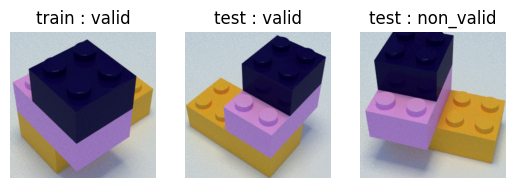

In [9]:
from matplotlib import axis
import random
from PIL import Image
import matplotlib.pyplot as plt

#1 Get directory path
train_path = Path(data_path, "synthetic_lego/train")
train_path_valid = Path(data_path, "synthetic_lego/train/valid")
test_path = Path(data_path, "synthetic_lego/test")
test_valid_path = Path(data_path, "synthetic_lego/test/valid")
test_non_valid_path = Path(data_path, "synthetic_lego/test/non_valid")

#2. Get lists of all image paths
train_path_list = list(train_path_valid.glob("*.jpg"))
test_valid_path_list = list(test_valid_path.glob("*.jpg"))
test_non_valid_path_list = list(test_non_valid_path.glob("*.jpg"))

#3.pick a random image
random_image_path_1 = random.choice(train_path_list)
random_image_path_2 = random.choice(test_valid_path_list)
random_image_path_3 = random.choice(test_non_valid_path_list)
image_paths = [random_image_path_1, random_image_path_2, random_image_path_3]

#4 Plot images
f, ax = plt.subplots(1,3)

for idx, path in enumerate(image_paths):
  ax[idx].imshow(Image.open(path))
  ax[idx].set_title(f"{path.parents[1].stem} : {path.parent.stem}")
  ax[idx].axison = False

### 1.1 Setting up a transform


In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Write a transform for images
standard_transform = torchvision.transforms.Compose([
    #Resize images to 224x224
    transforms.Resize(size=(224,224)),
    #turn the image into a torch tensor
    transforms.ToTensor()
])

### 1.2 Turn the images into a dataset

We use the Class `torchvision.datasets.ImageFolder`

This class inherits from `DatasetFolder` so the same methods can be overridden to customize the dataset. It takes a root directory and tranforms as input arguments to set up the dataset.

In [12]:
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=standard_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=standard_transform)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 140
     Root location: data/synthetic_lego/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 145
     Root location: data/synthetic_lego/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

### 1.3 Pass the dataset into a DataLoader which can feed the model with batched data.

In [13]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True )
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True )
train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x7f2697f42a70>,
 140,
 145)

In [14]:
# Get image and label from custom dataloader
img_batch, lbl_batch= next(iter(train_dataloader))

# Print out the shapes
img_batch.shape, lbl_batch.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

## 3. **Create model blueprint**

We create a class that can be instantiated to create a model object which will be the convolutional autoencoder model.

The class will be the blueprint for a small model that consists of an **encoder** that brings the input into an embedding and a **decoder** that takes the embedding and reconstructs an image. We add the embedding size as an argument for the model(default=128).

**The encoder:**

The encoder takes the image input and runs it thorugh:

- `Layer1 - Conv2d`
- `Layer2 - Conv2d`
- `Layer3 - MaxPool2d`
- `Layer4 - Flatten`
- `Layer5 - Linear`

At this point the data is a onde dimensional embedding of the size defined by the argument `embedding_size`. The decoder then runs the embedding through:

**The decoder:**
- `Layer6 - Linear`
- `Layer7 - Unflatten`
- `Layer9 - ConvTranspose2d`
- `Layer10 - ConvTranspose2d`



In [15]:
import torch.nn.functional as F
from torch import nn

# Creating a class for a convolutional autoencoder


class ConvAE(nn.Module):
    """Model architecture for a convolutional autoencoder.

    It returns a reconstruction of an input image.
    """
    def __init__(self, embedding_size: int = 128):

        super().__init__()

        #The Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=12544,out_features=embedding_size)

        #The Decoder
        self.fc2 = nn.Linear(in_features=embedding_size,out_features=12544)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(4,56,56))
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.t_conv1 = nn.ConvTranspose2d(in_channels=4, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoding
        x = F.relu(self.conv1(x))
        x, indices1 = self.pool(x)
        x = F.relu(self.conv2(x))
        x, indices2 = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        # Decoding
        x = self.fc2(x)
        x = self.unflatten(x)
        x = self.unpool(x, indices2)
        x = F.relu(self.t_conv1(x))
        x = self.unpool(x, indices1)
        x = F.sigmoid(self.t_conv2(x))

        return x

## 4. Train the model
To train the model we do the following:
1. Instantiate a model
2. Define loss function
3. Define an optimization algorithm
4. Set up a training loop
  1. Place data onto the right `device`
  2. Run data through the model
  3. Calculate the loss
  4. Backward propagation
  5. Perform optimzation step based on gradient descent
  6. Vizualise the progress


In [16]:
# 1. Instantiate a model
model = ConvAE(embedding_size=64).to(device)
# 2. Define a loss function
loss_function = torch.nn.MSELoss()
# 3. Define an optimization algorithm
optimizer = torch.optim.Adam(model.parameters())

model

ConvAE(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12544, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=12544, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(4, 56, 56))
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

  0%|          | 0/20 [00:00<?, ?it/s]

0.049825763795524836
0.01845820140359657
0.012183609488420188
0.010331108890074705
0.007153609504790178
0.0057466262535724255
0.0051534449116193825
0.004294682729856244
0.004127010465266982
0.0035442618120993885
0.0031451949949509333
0.0030242375513937856
0.0027434498171455095
0.002603058097052521
0.002508179455929037
0.0024677246867213396
0.00230370486387983
0.002578813933567809
0.00213960465126937
0.002019806415773928


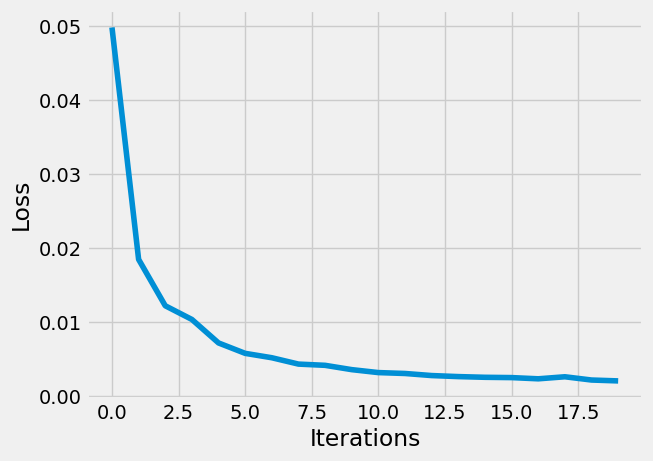

In [17]:
from tqdm.auto import tqdm
os.chdir(HOME)

model.train()
epochs = 20
outputs = []
losses = []
temp_losses= []

for epoch in tqdm(range(epochs)):
   for (image, _) in train_dataloader:

      # 4.1 Place data on the right device
      image = image.to(device)

      # 4.2 Run data throught the model
      reconstructed = model(image)

      # 4.3 Calculate the loss
      loss = loss_function(reconstructed, image)

      # 4.4 Run backward propagation
      optimizer.zero_grad()
      loss.backward()

      # 4.5 Perform optimzation step based on gradient descent
      optimizer.step()

      # 4.6 Vizualise the progress
      temp_losses.append(loss.cpu().detach().numpy())

   # 4.6 Vizualise the progress(continuation)
   print(sum(temp_losses)/len(train_dataloader))
   losses.append((sum(temp_losses)/len(train_dataloader)))
   temp_losses = []
   outputs.append((epochs, image, reconstructed))

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)

Text(0.5, 1.0, 'reconstruction')

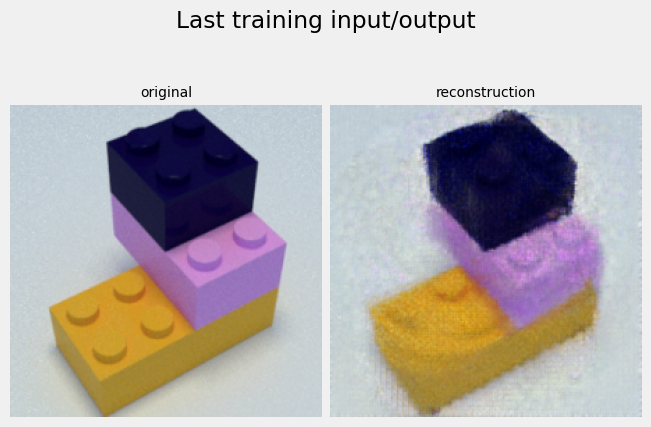

In [18]:
# A look at the last training data input and reconstruction

fig, ax = plt.subplots(1,2,layout='constrained')
fig.suptitle("Last training input/output")
ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())
ax[0].axis("off")
ax[0].set_title("original", size=10)
ax[1].imshow(reconstructed.squeeze().permute(1, 2, 0).cpu().detach().numpy())
ax[1].axis("off")
ax[1].set_title("reconstruction", size=10)

## 5. Run reconstruction on test dataset
For inferencing we set up a similair loop as for trianing but we skip some steps.

1. Place data onto the right `device`
2. Run data through the model
3. Store the reconstructed image
4. Calculate the loss
5. Store the loss and the label

The test dataset consists of images with the labels *valid* and *non_valid*.

In [19]:
os.chdir(HOME)
from typing import Tuple
def reconstructor(model: torch.nn.Module,
              loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """ Takes in a dataloader and runs reconstruction on all image data in the dataloader.

    Args:
      model: A PyTorch model to be used for reconstruction.
      dataloader: A DataLoader instance to get data input for the model.
      loss_fn: A PyTorch loss function to calculate the reconstruction loss.
      device: A target device to place objects onto.

    Returns:
    A tuple with 2 lists. First list with reconstruction losses and second list with class labels.
    In the form (losses, labels). For example:
    ([0.02, 0.002, 0.023], [0, 1, 0])

    """
    model.eval()

    losses = []
    labels = []
    index_non_valid =0
    index_valid = 0

    for batch, label in test_dataloader:
        if label.item() == 0:
          index_non_valid +=1
        else:
          index_valid += 1
        # 1. Place data onto the right device
        image = batch.to(device)

        # 2. Run data through the model
        reconstructed = model(image)

        # 3. Store the reconstructed image
        if index_non_valid == 1 and label.item()==0:
          rec_non_valid = reconstructed
        elif index_valid == 1 and label.item()==1:
          rec_valid = reconstructed
        elif label.item()==0:
          rec_non_valid = torch.cat((rec_non_valid,reconstructed),0)
        else:
          rec_valid = torch.cat((rec_valid,reconstructed),0)

        # 4. Calculate the loss
        loss = loss_function(reconstructed, image)

        # 5. Store the loss and the label
        losses.append(loss.cpu().detach().numpy())
        labels.append(label.cpu().detach().numpy())

    return losses, labels

reconstructions = reconstructor(model=model,
                                loader=test_dataloader,
                                loss_fn=loss_function,
                                device=device)

Lets turn the reconstructions into a pandas dataframe for better vizualization

In [20]:
import pandas as pd

df = pd.DataFrame({"losses":reconstructions[0], "labels":reconstructions[1], "class_names": reconstructions[1]})
df['class_names'] = df['class_names'].replace(1, 'VALID')
df['class_names'] = df['class_names'].replace(0, 'NON_VALID')
df = df.sort_values('labels')
df

,losses,labels,class_names
0,0.030216236,[0],NON_VALID
106,0.018095968,[0],NON_VALID
105,0.028934103,[0],NON_VALID
104,0.025261473,[0],NON_VALID
103,0.024438594,[0],NON_VALID
...,...,...,...
96,0.0029132932,[1],VALID
32,0.002697473,[1],VALID
102,0.0046434943,[1],VALID
13,0.0017813272,[1],VALID


Lets create a plot function to vizualise the reconstruction results.

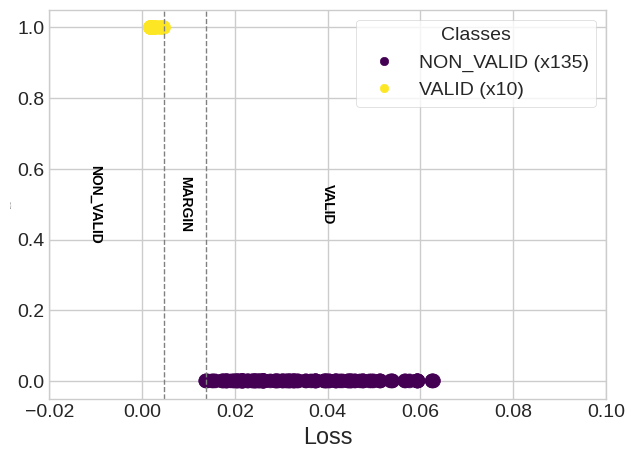

In [21]:
from matplotlib import pyplot as plt
from typing import List

def plot_binary(x: List,
                y: List,
                class_names: List):
    """Plots the values of two classes.

    Args:
      x: loss values
      y: class index
      class_names: names of class index

    Return:
      Returns a plot

    """
    with plt.style.context('seaborn-v0_8-whitegrid'):

        fig, ax = plt.subplots()
        ax.set_xlim(left=-0.02,right=0.1 )

        # Add the scatter plot
        scatter = ax.scatter(x, y, c=df.labels, s=100, cmap="viridis")

        # Add a legend for the plot
        legend1 = ax.legend(scatter.legend_elements()[0], (f"{class_names[0]} (x{str(y.value_counts()[0])})", f"{class_names[1]} (x{str(y.value_counts()[1])})"), loc="upper right", title="Classes", frameon=True)

        # Add some lines
        max_loss_valid = df.loc[df['labels'] == 1].max()[0]
        min_loss_non_valid = df.loc[df['labels'] == 0].min()[0]
        line1 = plt.axvline(x = min_loss_non_valid, color = 'grey', label = 'Threshold', linewidth=1, linestyle="dashed")
        line2 = plt.axvline(x = max_loss_valid, color = 'grey', label = 'Threshold', linewidth=1, linestyle="--")

        # Adding some text
        ax.annotate("MARGIN", ((min_loss_non_valid-max_loss_valid)/2+max_loss_valid, 0.5), color='black', weight='bold', fontsize=10, ha='center', va='center', rotation=270)
        ax.annotate(class_names[1], (0.04, 0.5), color='black', weight='bold', fontsize=10, ha='center', va='center', rotation=270)
        ax.annotate(class_names[0], (-0.01, 0.5), color='black', weight='bold', fontsize=10, ha='center', va='center', rotation=270)
        plt.xlabel("Loss")
        plt.ylabel("Class_Index", size=1)

        plt.show()


# Lets run the plot function with values from the created dataframe

plot_binary(x= df.losses,
            y= df.labels,
            class_names= df.class_names.unique())

It can be seen in the plot that the reconstruction errors between the two classes are seprated by a margin. This margin or a threshold line placed within the margin can be used to binary classify reconstructions as *VALID* or *NON_VALID*.


If we, for example, set a **threshold line to 0.01** then we would get the following classifier:

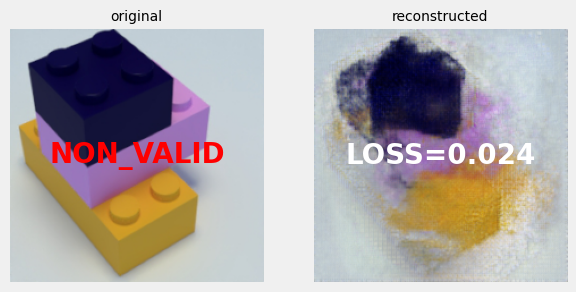

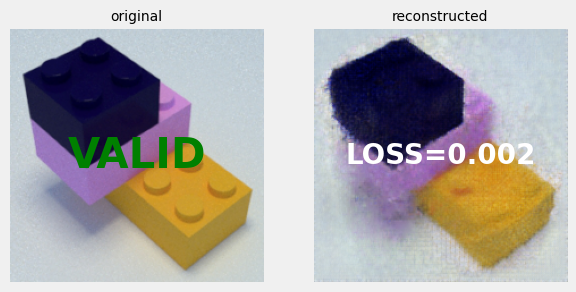

In [22]:
import os, random

def classify(model: torch.nn.Module,
            loss_fn: torch.nn.Module,
            device: torch.device,
            file_path: str,
            threshold: float):
    """ Takes an image and classifies it according to a reconstruction loss threshold.
    Args:
      model: A PyTorch model to be used for reconstruction.
      dataloader: A DataLoader instance to get data input for the model.
      loss_fn: A PyTorch loss function to calculate the reconstruction loss.
      device: A target device to place objects onto.
  	  threshold: A binary classifing threshold fro image classification.
    """

    # 1. get image and turin into tensor
    image = Image.open(file_path+"/"+random.choice(os.listdir(file_path)))
    image_tensor = standard_transform(image).to(device).unsqueeze(dim=0)

    # 2. Run a reconstruction in the model
    model.eval()
    reconstructed = model(image_tensor)

    # 3. Calculate the loss
    loss = loss_function(reconstructed, image_tensor)

    # 4. Plot
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    ax[0].axis("off")
    ax[0].set_title("original", size=10)
    ax[1].imshow(reconstructed.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    ax[1].axis("off")
    ax[1].set_title("reconstructed", size=10)

    if loss < threshold:
        ax[0].annotate("VALID", (112, 112), color='GREEN', weight='bold', fontsize=30, ha='center', va='center', rotation=0)
        ax[1].annotate("LOSS="+str(round(loss.item(),3)), (112, 112), color='WHITE', weight='bold', fontsize=20, ha='center', va='center', rotation=0)
    else:
        ax[0].annotate("NON_VALID", (112, 112), color='RED', weight='bold', fontsize=20, ha='center', va='center', rotation=0)
        ax[1].annotate("LOSS="+str(round(loss.item(),3)), (112, 112), color='WHITE', weight='bold', fontsize=20, ha='center', va='center', rotation=0)


classify(model=model,
         loss_fn=loss_function,
         device=device,
         file_path="/content/data/synthetic_lego/test/non_valid",
         threshold=0.01),
classify(model=model,
         loss_fn=loss_function,
         device=device,
         file_path="/content/data/synthetic_lego/test/valid",
         threshold=0.01)